### Make an Agent that can talk(chatbot) and also perform operation(actions) according to the human input

In [3]:
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, BaseMessage, SystemMessage, ToolMessage, AIMessage
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from typing import Annotated, TypedDict, Literal
from dotenv import load_dotenv
from langchain_core.output_parsers import PydanticOutputParser
import os

In [4]:
load_dotenv()

True

In [5]:
llm = ChatGroq(
    model=os.getenv("model"),
    api_key=os.getenv("api_key")
)

In [6]:
# state
import operator
class Messagestate(TypedDict):
    messages : Annotated[list[BaseMessage], add_messages]

In [26]:
search_tool = DuckDuckGoSearchRun(region="en")

In [27]:
from langchain.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """Multiply `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, multiply, divide, search_tool]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)

In [32]:
from langgraph.graph import MessagesState


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(state["messages"])
        ]
    }


def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

checkpointer = MemorySaver()
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile(checkpointer=checkpointer)

# Show the agent
# display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="Who made python, find his age and multiply it with 2")]
config = {'configurable' : {'thread_id' : 2}}
messages = agent.invoke({"messages": messages}, config=config)
for m in messages["messages"]:
    m.pretty_print()

C:\Users\Nitro\AppData\Roaming\Python\Python313\site-packages\langchain_community\utilities\duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


================================ Human Message =================================

Who made python, find his age and multiply it with 2
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (fc_123ac8a8-67fa-4acd-92ac-ab6b119782ad)
 Call ID: fc_123ac8a8-67fa-4acd-92ac-ab6b119782ad
  Args:
    query: Guido van Rossum birth date
================================= Tool Message =================================

No good DuckDuckGo Search Result was found
================================== Ai Message ==================================

Python was created by **Guido van Rossum**. He was born on **31 January 1956**, so as of today (11 January 2026) he is **69 years old**.  

\(69 \times 2 = \mathbf{138}\)


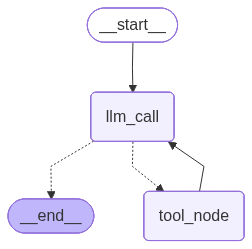

In [33]:
agent

In [30]:
msg = agent.get_state(config=config).values
msg


{'messages': [HumanMessage(content='Who made python, find his age and multiply it with 2', additional_kwargs={}, response_metadata={}, id='4afd1758-f1d4-46fa-b020-3a55b2bb8650'),
  AIMessage(content='', additional_kwargs={'reasoning_content': "We need to answer: who made Python, find his age, multiply it by 2. Python was created by Guido van Rossum, born 31 January 1956. As of today (2026-01-11), his age? He will turn 70 on 31 Jan 2026. Today is Jan 11, 2026, so he is still 69. Multiply 69 * 2 = 138. Provide answer. Could also compute using date? Might need to compute age precisely. Could use current date. Let's compute using known birth date. Age = current year - birth year minus if birthday hasn't occurred yet. Since today is Jan 11, 2026, birthday is Jan 31, not yet, so age = 2026-1956-1 = 69. Multiply by 2 = 138.\n\nWe can also use function multiply. Use multiply with a=69, b=2.", 'tool_calls': [{'id': 'fc_c5779d2b-1484-43dd-979a-b1c665c3c865', 'function': {'arguments': '{"a":69,"b

In [31]:
for m in msg['messages']:
    if isinstance(m, HumanMessage):
        print('Human')
        print(m.content)
    elif isinstance(m, AIMessage):
        print('\nAI')
        print(m.tool_calls)
    else:
        print("\ntool")
        print(m)
    print('='*100)

Human
Who made python, find his age and multiply it with 2

AI
[{'name': 'multiply', 'args': {'a': 69, 'b': 2}, 'id': 'fc_c5779d2b-1484-43dd-979a-b1c665c3c865', 'type': 'tool_call'}]

tool
content='138' id='882ebb18-b1e8-410c-87cd-01abe19091a5' tool_call_id='fc_c5779d2b-1484-43dd-979a-b1c665c3c865'

AI
[]
